# 16. 모델 신뢰
#### 예측 모델의 잠재적 품질을 정량화하는 두 가지 방법
1. **모호한 영역 (Equivocal zones)** : 예측 값을 사용하여 결과가 의심스러울 수 있는 정도를 측정
2. **적용 가능성 (Applicability)** : 설명변수를 사용하여, 새 표본에 대한 외삽의 양을 측정

In [2]:
library(tidymodels)
library(applicable)
library(patchwork)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

<br>

## 16.01. 모호한 영역 (Equivocal zones)

<br>

#### 이진 분류 시뮬레이션 예제

- 두 개의 변수를 가진 데이터를 활용한 이진 분류 시뮬레이션
- 분류 모델은 아래와 같은 연결함수를 사용하는 로지스틱 회귀 모델

$$\mathrm{logit}(p) = -1 - 2x - \frac{x^2}{5} + 2y^2$$

- 두 변수는 상관 관계가 0.70인 이변량 정규 분포를 따르며, 
    
    200개의 샘플로 구성된 훈련데이터와 50개의 테스트 데이터를 생성

In [3]:
simulate_two_classes <- function (n, error = 0.1, eqn = quote(-1 - 2 * x - 0.2 * x^2 + 2 * y^2))  {

    sigma <- matrix(c(1, 0.7, 0.7, 1), nrow = 2, ncol = 2)
    dat <- MASS::mvrnorm(n = n, mu = c(0, 0), Sigma = sigma)
    colnames(dat) <- c("x", "y")
    cls <- paste0("class_", 1:2)
    dat <- 
      as_tibble(dat) %>% 
      mutate(
        linear_pred = !!eqn,
        # Add some misclassification noise
        linear_pred = linear_pred + rnorm(n, sd = error),
        prob = binomial()$linkinv(linear_pred),
        class = ifelse(prob > runif(n), cls[1], cls[2]),
        class = factor(class, levels = cls)
      )
    dplyr::select(dat, x, y, class)
    }

In [4]:
set.seed(1901)
training_set <- simulate_two_classes(200)
testing_set  <- simulate_two_classes(50)

- 베이지안 방법 (모수에 대한 기본 가우스 사전 분포 사용)을 사용하여 로지스틱 회귀 모델 생성

In [5]:
two_class_mod <- logistic_reg() %>% 
    set_engine("stan", seed = 1902) %>% 
    fit(class ~ . + I(x^2)+ I(y^2), data = training_set)

print(two_class_mod, digits = 3)

parsnip model object

stan_glm
 family:       binomial [logit]
 formula:      class ~ . + I(x^2) + I(y^2)
 observations: 200
 predictors:   5
------
            Median MAD_SD
(Intercept)  1.092  0.287
x            2.290  0.423
y            0.314  0.354
I(x^2)       0.077  0.307
I(y^2)      -2.465  0.424

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


<br>

- **모델의 클래스 분류 경계에 가장 가까운 데이터 포인트는 불확실성을 (모호함) 띄고 있음 (분류 확률 $\approx$ 50%)**
    
    $\rightarrow$ **데이터 포인트의 값이 약간이라도 변경되면, 예측 클래스가 변경 될 수 있음을 의미**
    


In [9]:
data_grid <- crossing(
    x = seq(-4.5, 4.5, length = 100),
    y = seq(-4.5, 4.5, length = 100)
  )

In [10]:
grid_pred <- predict(two_class_mod, data_grid, type = "prob") %>% 
    bind_cols(
      predict(two_class_mod, data_grid, type = "pred_int", std_error = TRUE),
      data_grid
    )

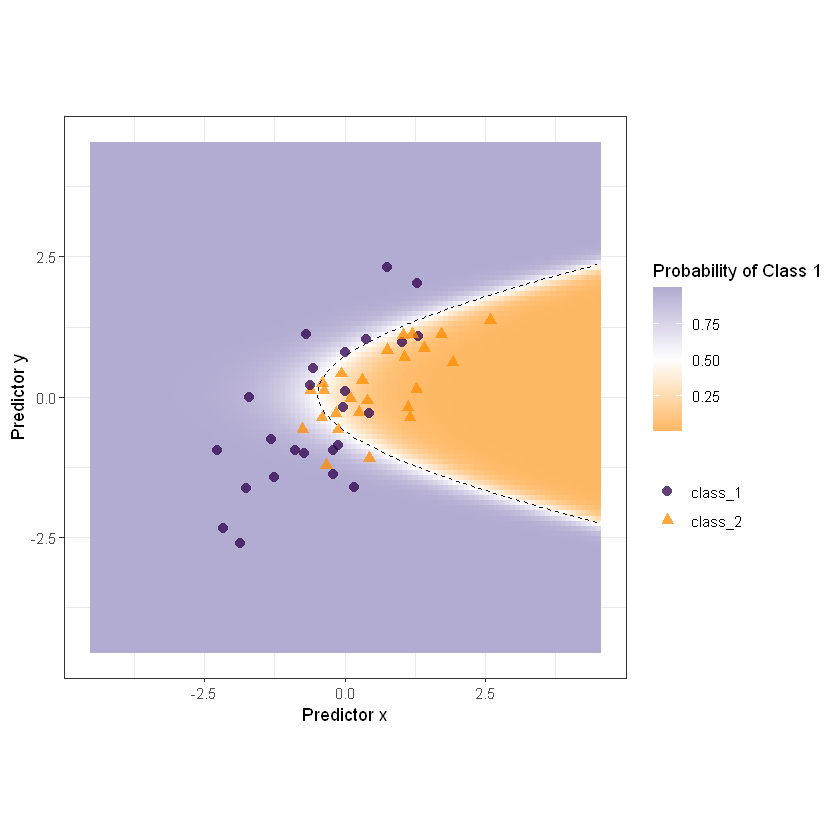

In [8]:
grid_pred %>% 
    mutate(`Probability of Class 1` = .pred_class_1) %>% 
    ggplot(aes(x = x, y = y)) + 
    geom_raster(aes(fill = `Probability of Class 1`)) +
    geom_point(data = testing_set, aes(shape = class, color = class), alpha = .75, size = 2.5) + 
    geom_contour(aes(z = .pred_class_1), breaks = .5, color = "black", lty = 2) + 
    coord_equal() + 
    labs(x = "Predictor x", y = "Predictor y", color = NULL, shape = NULL) + 
    scale_fill_gradient2(low = "#FDB863", mid = "white", high = "#B2ABD2", midpoint = .5) + 
    scale_color_manual(values = c("#2D004B", "darkorange"))

<br>

#### 분류 임계점 결정


- **클래스 분류 경계 주이의 밴드 폭을 기반으로, 모호한 결과가 제거될 때 성능이 어떻게 향상되는지 추정할 수 있으며,**
    
    **보고 가능 비율 (Reportable, 모호하지 않은 비율)도 추정할 수 있음**

- **테스트 데이터를 사용하여, 성능 향상 결과와 보고 가능 비율 간의 균형을 결정**

<br>

- 테스트 데이터의 각 관측값별 분류 확률과 분류 결과

In [21]:
test_pred <- augment(two_class_mod, testing_set)
test_pred %>% head()

.pred_class,.pred_class_1,.pred_class_2,x,y,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
class_2,0.025576852,0.9744231,1.1198640,-0.1758583,class_2
class_1,0.555147708,0.4448523,-0.1258177,-0.5823101,class_2
class_2,0.006196573,0.9938034,1.9227174,0.6154449,class_2
class_2,0.472309328,0.5276907,-0.3997295,0.2522317,class_2
class_2,0.162665824,0.8373342,1.3005536,1.0887124,class_1
class_2,0.031677420,0.9683226,2.5863479,1.3632762,class_2


<br>

#### `probably::make_two_class_pred()` : 이진 분류 문제에서 모호한 영역에 있는 관측값들을 식별

In [22]:
library(probably)

In [23]:
lvls <- levels(training_set$class)

- **분류확률이 $50\% \pm 15\%$ 사이인 관측값들을 모호한 값들로 분류 (`buffer = 0.15`)**

In [24]:
test_pred <- test_pred %>% 
    mutate(.pred_with_eqz = make_two_class_pred(.pred_class_1, lvls, buffer = 0.15))

In [27]:
test_pred %>% head

.pred_class,.pred_class_1,.pred_class_2,x,y,class,.pred_with_eqz
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<clss_prd>
class_2,0.025576852,0.9744231,1.1198640,-0.1758583,class_2,class_2
class_1,0.555147708,0.4448523,-0.1258177,-0.5823101,class_2,[EQ]
class_2,0.006196573,0.9938034,1.9227174,0.6154449,class_2,class_2
class_2,0.472309328,0.5276907,-0.3997295,0.2522317,class_2,[EQ]
class_2,0.162665824,0.8373342,1.3005536,1.0887124,class_1,class_2
class_2,0.031677420,0.9683226,2.5863479,1.3632762,class_2,class_2


In [34]:
test_pred %>% group_by(.pred_with_eqz) %>% count() %>% ungroup

.pred_with_eqz,n
<clss_prd>,<int>
[EQ],9
class_1,20
class_2,21


<br>

- 모호한 영역을 제거하지 않은 예측결과의 혼동행렬과 정확도 (78%)

In [32]:
test_pred %>% conf_mat(class, .pred_class)
print(39/50)

          Truth
Prediction class_1 class_2
   class_1      20       6
   class_2       5      19

[1] 0.78


- 모호한 영역을 제거 (보고 가능한 영역)한 예측결과의 혼동행렬과 정확도 (80.48%)

In [33]:
test_pred %>% conf_mat(class, .pred_with_eqz)
print(33/41)

          Truth
Prediction class_1 class_2
   class_1      17       3
   class_2       5      16

[1] 0.804878


<br>

#### 모호한 영역의 크기가 모델 성능에 미치는 영향
- 모호한 영역의 크기가 증가할수록, 보고 가능한 영역에서의 정확도가 증가

In [35]:
eq_zone_results <- function(buffer) {
    test_pred <- test_pred %>% 
        mutate(.pred_with_eqz = make_two_class_pred(.pred_class_1, lvls, buffer = buffer))
        acc <- test_pred %>% accuracy(class, .pred_with_eqz)
        rep_rate <- reportable_rate(test_pred$.pred_with_eqz)
        tibble(accuracy = acc$.estimate, reportable = rep_rate, buffer = buffer)
}

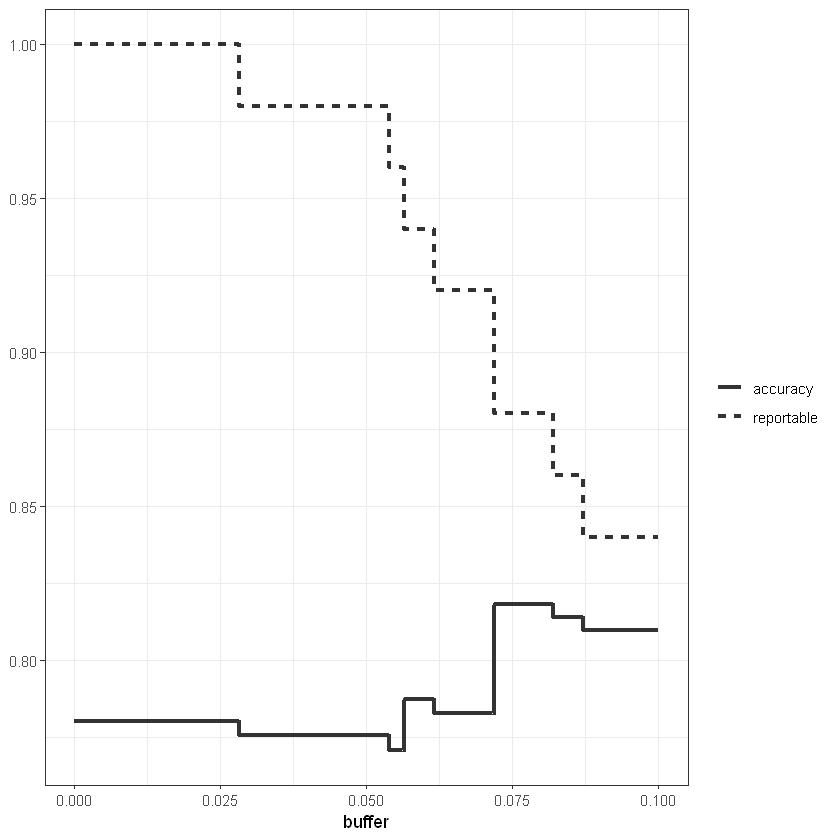

In [36]:
map(seq(0, .1, length.out = 40), eq_zone_results) %>% 
    list_rbind() %>% 
    pivot_longer(c(-buffer), names_to = "statistic", values_to = "value") %>% 
    ggplot(aes(x = buffer, y = value, lty = statistic)) + 
    geom_step(linewidth = 1.2, alpha = 0.8) + 
    labs(y = NULL, lty = NULL)

<br>

### 표준오차
- **해당 모델은 베이지안 모델을 사용하였기에, 분류확률은 사후예측분포의 평균**

    $\rightarrow$ **베이지안 모델은 클래스 확률에 대한 분포를 제공**
    
    $\rightarrow$ **분포의 표준편차를 측정하면, 확률 예측의 표준오차를 확인 가능**

<br>

- **이진 분류 문제에서의 베르누이 분포 (이항분포군)에서의 오차는 $p=0.5$일 때 가장 크기에**
    
    $\rightarrow$ **분류확률에 대한 임게점이 아닌, 표준오차에 대한 임계점을 할당하여 모호한 영역 정의 가능**

In [38]:
test_pred <- test_pred %>% 
    bind_cols(
    predict(two_class_mod, testing_set, type = "pred_int", std_error = TRUE)
)

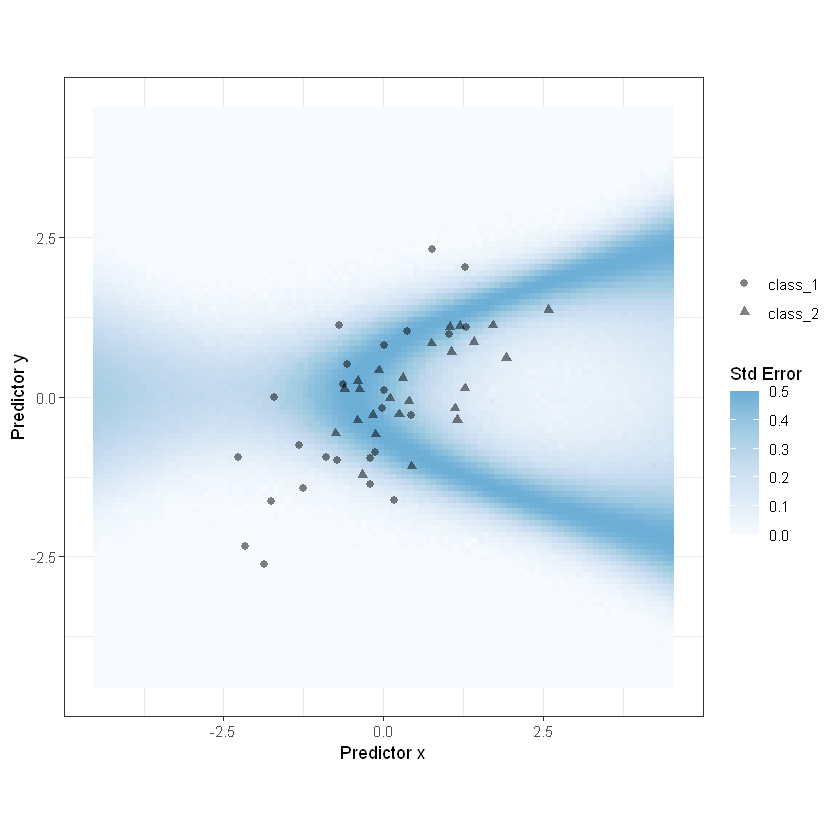

In [40]:
grid_pred %>% 
    mutate(`Std Error` = .std_error) %>% 
    ggplot(aes(x = x, y = y)) + 
    geom_raster(aes(fill = `Std Error`)) + 
    scale_fill_gradientn(colours = c("#F7FBFF", "#DEEBF7", "#C6DBEF", "#9ECAE1", "#6BAED6")) + 
    geom_point(data = testing_set, aes(shape = class), alpha = .5, size = 2) + 
    coord_equal() + 
    labs(x = "Predictor x", y = "Predictor y", shape = NULL)

<br>

## 16.02. 모델 적용 가능성
- 모호한 영역은 모델의 예측값을 기반으로 예측의 신뢰성을 측정
- **예측의 표준오차와 같은 모델 통계로는 외삽의 영향을 측정할 수 없으므로,** 
    
    **예측을 신뢰할 수 있는지 평가하고, '모델이 특정 데이터 포인트를 예측하는 데 적용 가능한지'에 대한 평가 방법이 필요**

In [41]:
data(Chicago)

In [42]:
Chicago <- Chicago %>% select(ridership, date, one_of(stations))
n <- nrow(Chicago)
Chicago_train <- Chicago %>% slice(1:(n - 14))
Chicago_test  <- Chicago %>% slice((n - 13):n)

<br>

#### 전처리 레시피 정의
- 날짜 변수(`date`)에서 관련 정보를 추출 (예: 요일, 월, 연도).
- 특정 날짜가 공휴일인지 여부를 나타내는 이진 변수를 생성
- 모든 범주형 변수를 더미 변수로 변환합
- 분산이 0인 변수에 대해 제거
- `station`에 대한 모든 변수를 정규화
- `station`에 대한 20개의 모든 변수를 PLS를 통하여 10개의 변수로 축소 

In [54]:
stations

[1] "Austin"           "Quincy_Wells"     "Belmont"          "Archer_35th"     
 [5] "Oak_Park"         "Western"          "Clark_Lake"       "Clinton"         
 [9] "Merchandise_Mart" "Irving_Park"      "Washington_Wells" "Harlem"          
[13] "Monroe"           "Polk"             "Ashland"          "Kedzie"          
[17] "Addison"          "Jefferson_Park"   "Montrose"         "California"

In [44]:
base_recipe <- recipe(ridership ~ ., data = Chicago_train) %>%
    step_date(date) %>%
    step_holiday(date, keep_original_cols = FALSE) %>%
    step_dummy(all_nominal()) %>%
    step_zv(all_predictors()) %>%
    step_normalize(!!!stations)%>%
    step_pls(!!!stations, num_comp = 10, outcome = vars(ridership))

<br>

#### 선형회귀 워크플로 생성

In [48]:
lm_spec <- linear_reg() %>%
    set_engine("lm") 

In [46]:
lm_wflow <- workflow() %>%
    add_recipe(base_recipe) %>%
    add_model(lm_spec)

In [47]:
set.seed(1902)
lm_fit <- fit(lm_wflow, data = Chicago_train)

<br>

#### 모델 확인
- 테스트 데이터에 대해서 어느정도 낮지 않은 성능을 보임을 확인

In [55]:
res_test <- predict(lm_fit, Chicago_test) %>%
    bind_cols(
        predict(lm_fit, Chicago_test, type = "pred_int"),
    Chicago_test
)

In [56]:
res_test %>% select(date, ridership, starts_with(".pred"))

date,ridership,.pred,.pred_lower,.pred_upper
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-15,20.636,20.325343,16.196779,24.45391
2016-08-16,21.050,21.278523,17.148622,25.40842
2016-08-17,21.032,21.437966,17.309083,25.56685
2016-08-18,21.301,21.413970,17.285163,25.54278
2016-08-19,20.446,20.852716,16.723239,24.98219
2016-08-20,6.225,7.517610,3.338842,11.69638
2016-08-21,6.619,6.343471,2.190344,10.49660
2016-08-22,21.157,20.213002,16.083937,24.34207
2016-08-23,21.323,21.256600,17.129129,25.38407


In [58]:
res_test %>% rmse(ridership, .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.8653286


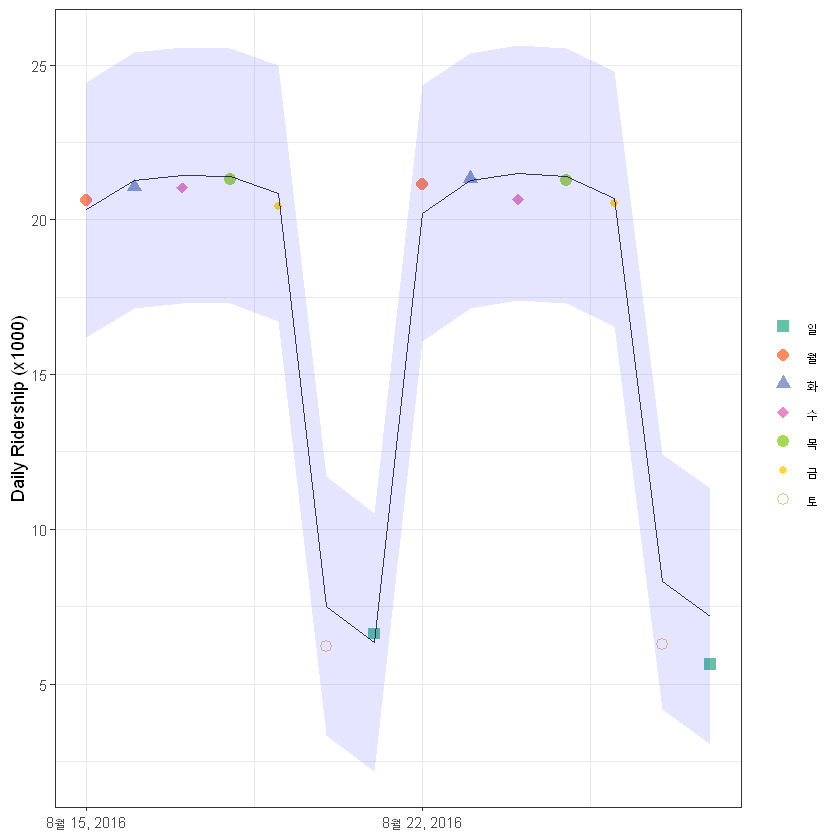

In [74]:
res_test %>%
    mutate(day = lubridate::wday(date, label = T)) %>%
    ggplot(aes(x = date)) +
    geom_point(aes(y = ridership, color = day, pch = day), size = 3) +
    geom_line(aes(y = .pred), alpha = .75) +
    geom_ribbon(aes(ymin = .pred_lower, ymax = .pred_upper), fill = "blue", alpha = .1)  +
    scale_color_brewer(palette = "Set2") +
    scale_shape_manual(values = 15:22) +
    scale_x_date(labels = date_format("%B %d, %Y")) +
    labs(x = NULL, y = "Daily Ridership (x1000)", color = NULL, pch = NULL)

<br>

#### 테스트 데이터의 기간보다 더 먼 미래의 기간에 대한 예측
- 2020년의 코로나 팬데믹을 고려할 때, 예측 모델의 성능은 현저히 감소

In [78]:
load("Chicago_2020.RData")

In [79]:
res_2020 <- predict(lm_fit, Chicago_2020) %>%
    bind_cols(
        predict(lm_fit, Chicago_2020, type = "pred_int"),
        Chicago_2020
    ) 

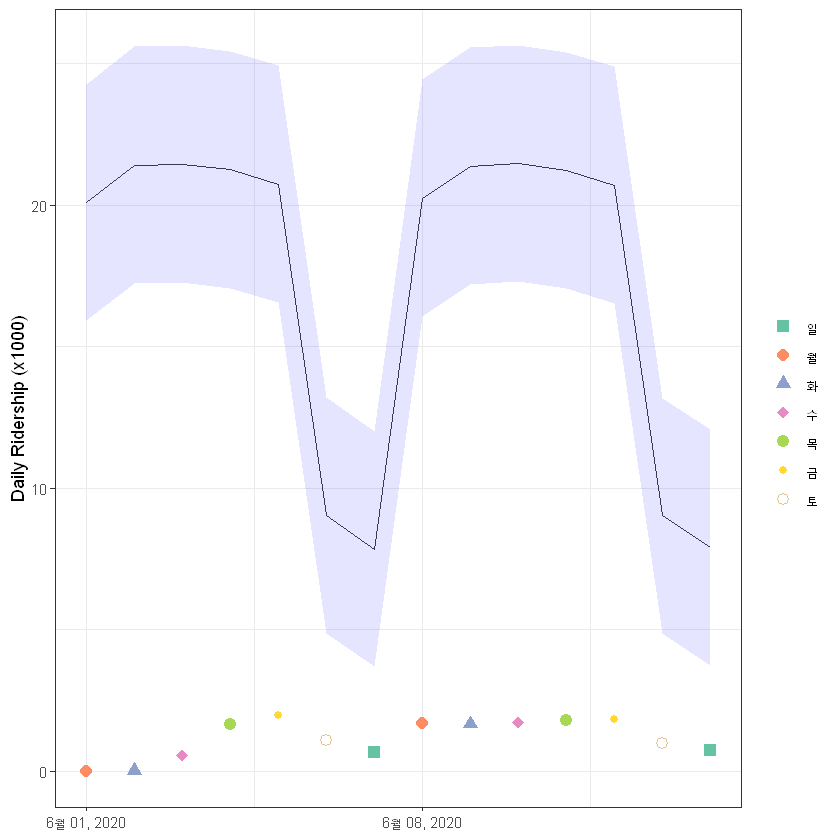

In [80]:
res_2020 %>%
    mutate(day = lubridate::wday(date, label = T)) %>%
    ggplot(aes(x = date)) +
    geom_point(aes(y = ridership, color = day, pch = day), size = 3) +
    geom_line(aes(y = .pred), alpha = .75) +
    geom_ribbon(aes(ymin = .pred_lower, ymax = .pred_upper), fill = "blue", alpha = .1) +
    scale_shape_manual(values = 15:22) +
    scale_color_brewer(palette = "Set2") +
    scale_x_date(labels = date_format("%B %d, %Y")) +
    labs(x = NULL, y = "Daily Ridership (x1000)", color = NULL, pch = NULL) 

<br>

### 모델의 적용성 계산
- **예측에 사용할 데이터와, 훈련에 사용된 데이터와의 비교**

<br>

#### PCA
1. **훈련 데이터의 변수별 상관관계 확인**

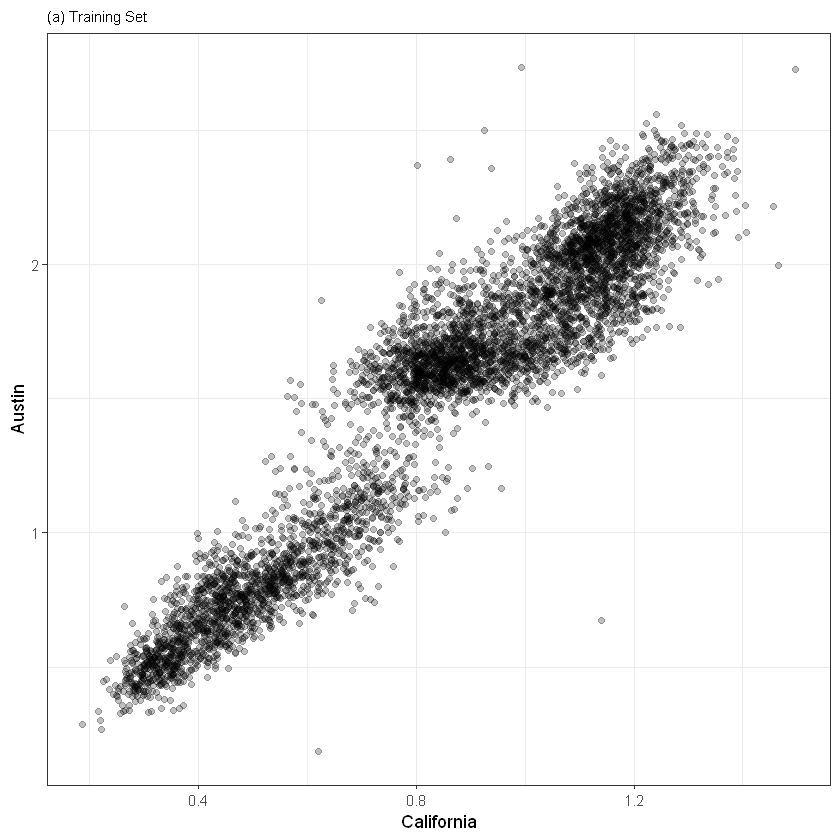

In [90]:
tr_plot <- Chicago_train %>% 
    ggplot(aes(x = California, y = Austin)) + 
    geom_point(alpha = .25) + 
    labs(title = "(a) Training Set") + 
    theme(plot.title = element_text(size=9))

tr_plot

<br>

#### 2. 높은 상관관계를 가지는 변수들에 대하여 차원축소

In [83]:
pca_rec <- recipe(~ ., data = Chicago_train) %>% 
    step_normalize(California, Austin) %>% 
    step_pca(California, Austin, num_comp = 2) %>% 
    prep()

In [84]:
training_pca <- bake(pca_rec, new_data = NULL)

- 주성분 (`PC1`, `PC2`) 확인

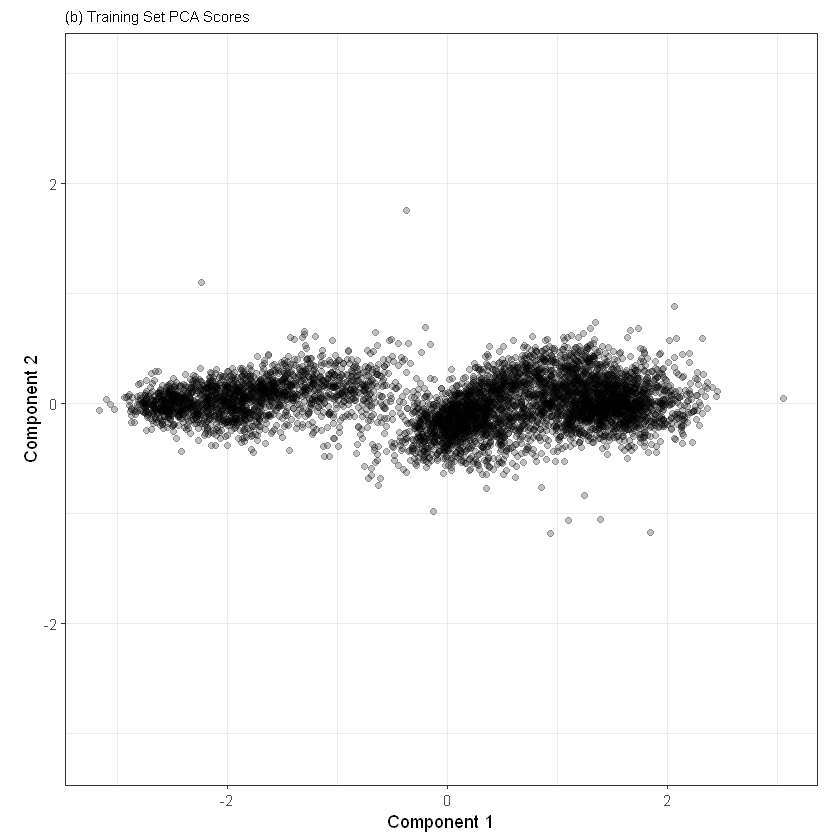

In [89]:
pca_plot <- training_pca %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(alpha = .25) + 
    coord_obs_pred() + 
    labs(x = "Component 1", y = "Component 2", title = "(b) Training Set PCA Scores") +
    theme(plot.title = element_text(size = 9))

pca_plot

<br>

3. **각 훈련 데이터의 관측값에서 각 주성분의 중심값 (평균)까지의 거리 측정**

In [93]:
pca_center <- training_pca %>% 
    select(PC1, PC2) %>% 
    summarize(PC1_mean = mean(PC1), PC2_mean = mean(PC2))

training_pca <- cbind(pca_center, training_pca) %>% 
    mutate(
        distance = (PC1 - PC1_mean)^2 + (PC2 - PC2_mean)^2,
        distance = sqrt(distance)
    )

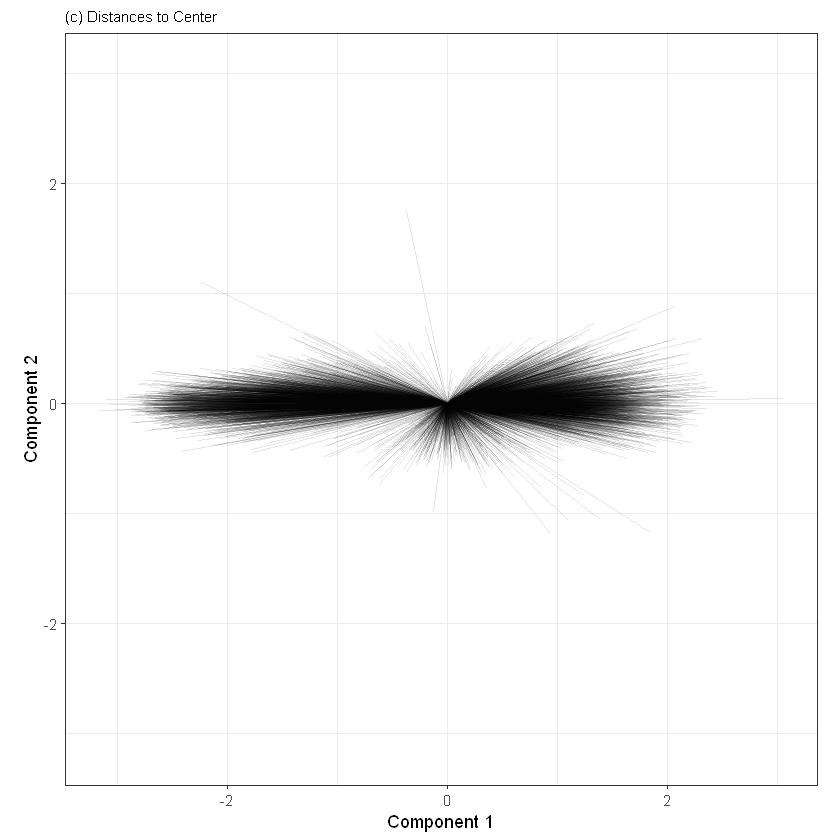

In [94]:
pca_dist <- training_pca %>% 
    ggplot() + 
    geom_segment(aes(x = PC1_mean, y = PC2_mean,
                     xend = PC1, yend = PC2), alpha = .1)  + 
    coord_obs_pred() + 
    labs(x = "Component 1", y = "Component 2", title = "(c) Distances to Center") +
    theme(plot.title = element_text(size = 9))

pca_dist

- 훈련 데이터의 주성분과, 주성분의 평균 간 거리의 분포

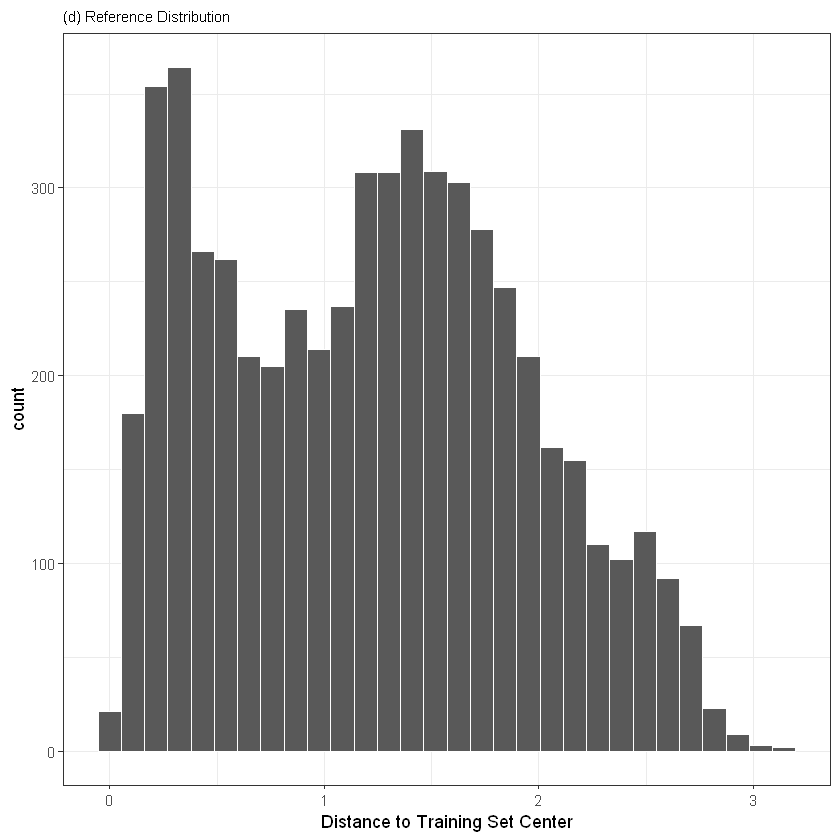

In [103]:
dist_hist <- training_pca %>%
    ggplot(aes(x = distance)) +
    geom_histogram(bins = 30, color = "white") +
    labs(x = "Distance to Training Set Center", title = "(d) Reference Distribution") +
    theme(plot.title = element_text(size = 9))

dist_hist

<br>

4. **에측에 사용될 데이터에 대하여 동일한 조합으로 차원 축소후, 훈련 데이터를 통해 도출된 주성분들의 중심값과의 거리 측정**

- 테스트 데이터

In [107]:
testing_pca <- bake(pca_rec, Chicago_test %>% slice(1)) %>% 
    cbind(pca_center) %>% 
    mutate(
        distance = (PC1 - PC1_mean)^2 + (PC2 - PC2_mean)^2,
        distance = sqrt(distance)
    )

testing_pctl <- round(mean(training_pca$distance <= testing_pca$distance) * 100, 1)

- 신규 데이터

In [108]:
new_pca <- bake(pca_rec, Chicago_2020 %>% slice(6)) %>% 
    cbind(pca_center) %>% 
    mutate(
        distance = (PC1 - PC1_mean)^2 + (PC2 - PC2_mean)^2,
        distance = sqrt(distance)
    )

new_pctl <- round(mean(training_pca$distance <= new_pca$distance) * 100, 1)

In [111]:
test_pca_dist <- training_pca %>% 
    ggplot() + 
    geom_segment(
        aes(x = PC1_mean, y = PC2_mean, xend = PC1, yend = PC2), 
        alpha = .05
    )  + 
    geom_segment(
        data = testing_pca,
        aes(x = PC1_mean, y = PC2_mean, xend = PC1, yend = PC2), 
        color = "lightblue",
        lty = 2
    )  + 
    geom_segment(
        data = new_pca,
        aes(x = PC1_mean, y = PC2_mean, xend = PC1, yend = PC2), 
        color = "red"
    )  + 
    geom_point(data = testing_pca, aes(x = PC1, y = PC2), color = "lightblue", size = 2, pch = 17) +
    geom_point(data = new_pca, aes(x = PC1, y = PC2), size = 2, color = "red") +
    coord_obs_pred() + 
    labs(x = "Component 1", y = "Component 2", title = "Distances to Training Set Center") + 
    theme_bw() + 
    theme(legend.position = "top")

<br>

- **테스트 데이터의 주성분과 훈련 데이터 주성분 중심값과의 거리보다, 신규 데이터가 더 멀리 있음**

    $\rightarrow$ **신규 데이터가 매우 극단적이며, 예측에 사용되어서는 안됨**

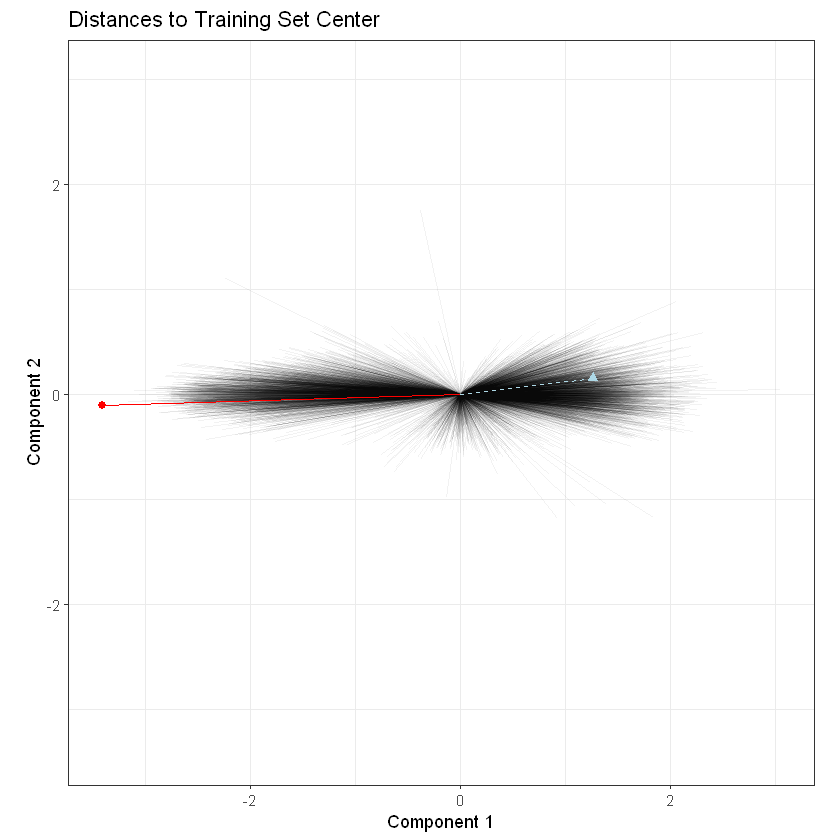

In [113]:
test_pca_dist

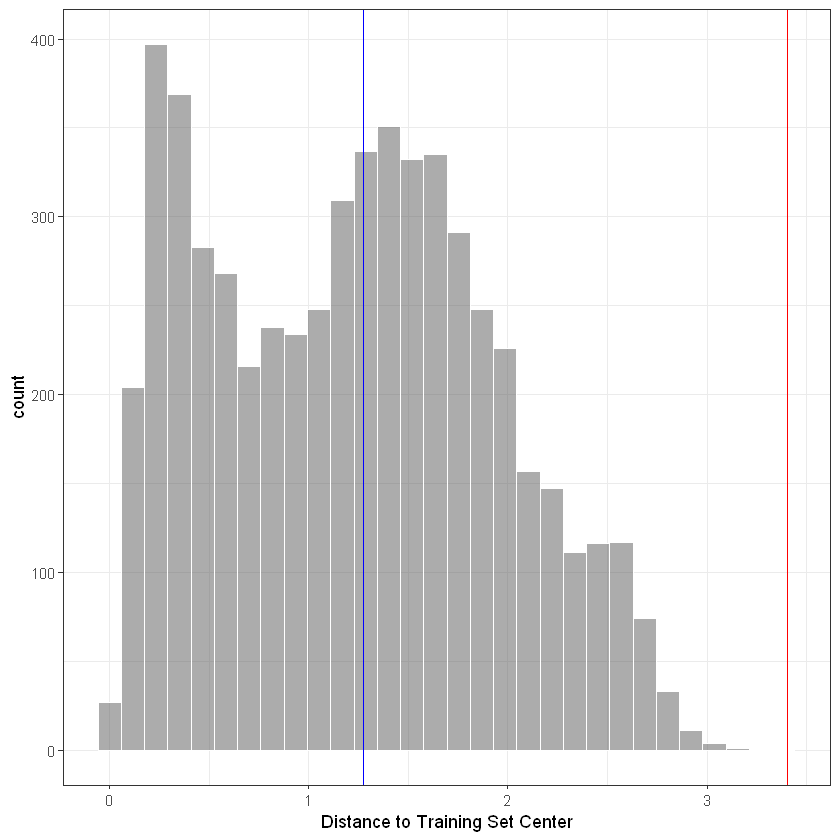

In [125]:
test_dist_hist <- training_pca %>% 
    ggplot(aes(x = distance)) + 
    geom_histogram(bins = 30, color = "white", alpha = .5) + 
    geom_vline(xintercept = testing_pca$distance, color = "blue") +
    geom_vline(xintercept = new_pca$distance, color = "red") +
    xlab("Distance to Training Set Center")

test_dist_hist

<br>

#### `applicable::add_pca()`



In [98]:
library(applicable)

<br>

- 전체 훈련 데이터에서 `station` 변수에 의한 변동 중 99%를 설명하기위한 PCA 진행
    
    $\rightarrow$ 9개의 주성분

In [99]:
pca_stat <- apd_pca(~ ., data = Chicago_train %>% select(one_of(stations)), 
                    threshold = 0.99)
pca_stat

# Predictors:
   20
# Principal Components:
   9 components were needed
   to capture at least 99% of the
   total variation in the predictors.

<br>

- 훈련 데이터의 주성분 값들과, 주성분의 중심간 거리에 대한 누적분포

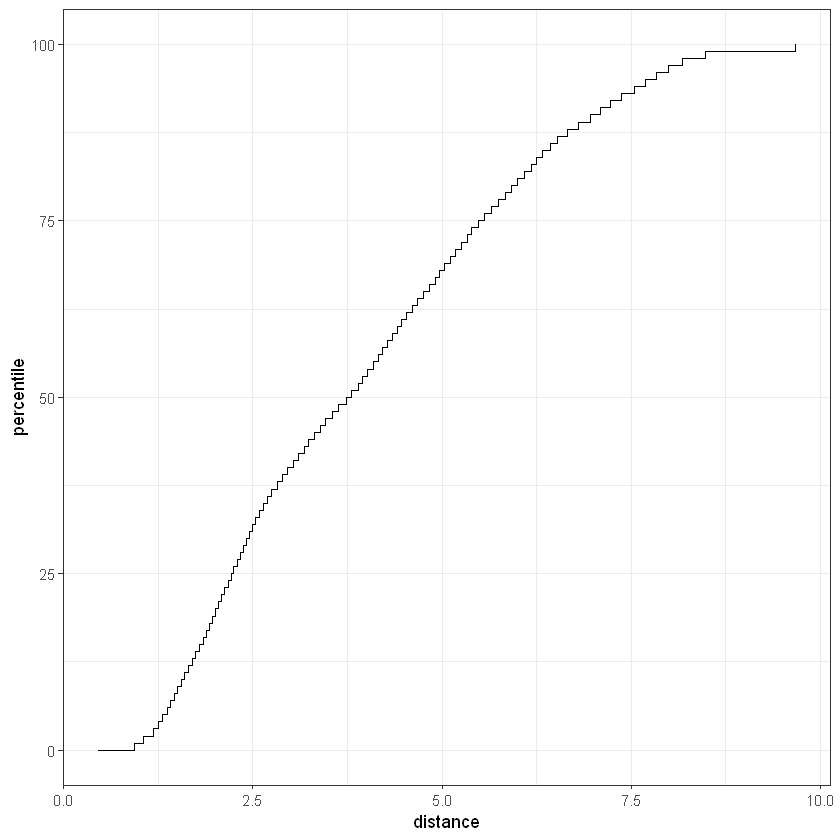

In [100]:
autoplot(pca_stat, distance) + labs(x = "distance")

- 테스트 데이터의 주성분 값과 훈련 데이터의 주성분 중심값들 간 거리와, 
    
    해당 값들이 훈련 데이터 기준의 거리분포에서 차지하는 분위수

In [101]:
score(pca_stat, Chicago_test) %>% select(starts_with("distance"))

distance,distance_pctl
<dbl>,<dbl>
4.884756,66.67022
5.211386,71.41448
5.189640,71.13339
5.000708,68.51589
4.360550,59.29044
4.103237,55.20784
5.594810,76.36399
4.208854,56.94668
4.936399,67.45598


- 신규 데이터의 주성분 갑소가 훈련 데이터의 주성분 중심값들 간 거리와,
    
    해당 값들이 훈련 데이터 기준의 거리분포에서 차지하는 분위수
    
    $\rightarrow$ 신규 데이터의 주성분 값들의 분위수는 99% 혹은 100%로서, 훈련 데이터 기준의 거리분포에서 극단적인 위치에 있음을 확인
    
    $\rightarrow$ 예측에 사용되서는 안됨

In [102]:
score(pca_stat, Chicago_2020) %>% select(starts_with("distance"))

distance,distance_pctl
<dbl>,<dbl>
9.386831,99.75711
9.397354,99.76595
9.295253,99.68021
9.295889,99.68074
9.291976,99.67746
10.062111,1.00000
10.164061,1.00000
10.127716,1.00000
9.303493,99.68713
